# 서울시 범죄 현황 분석

In [73]:
# 필요한 패키지 import
from IPython.display import Image
import numpy as np
import pandas as pd
import googlemaps
from sklearn import preprocessing

# 시각화를 위한 패키지
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc # 한글 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font',family = 'AppleGothic')
elif platform.system()=='Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font',family = font_name)
else:
    print('Unknown System... ')

import folium
import json

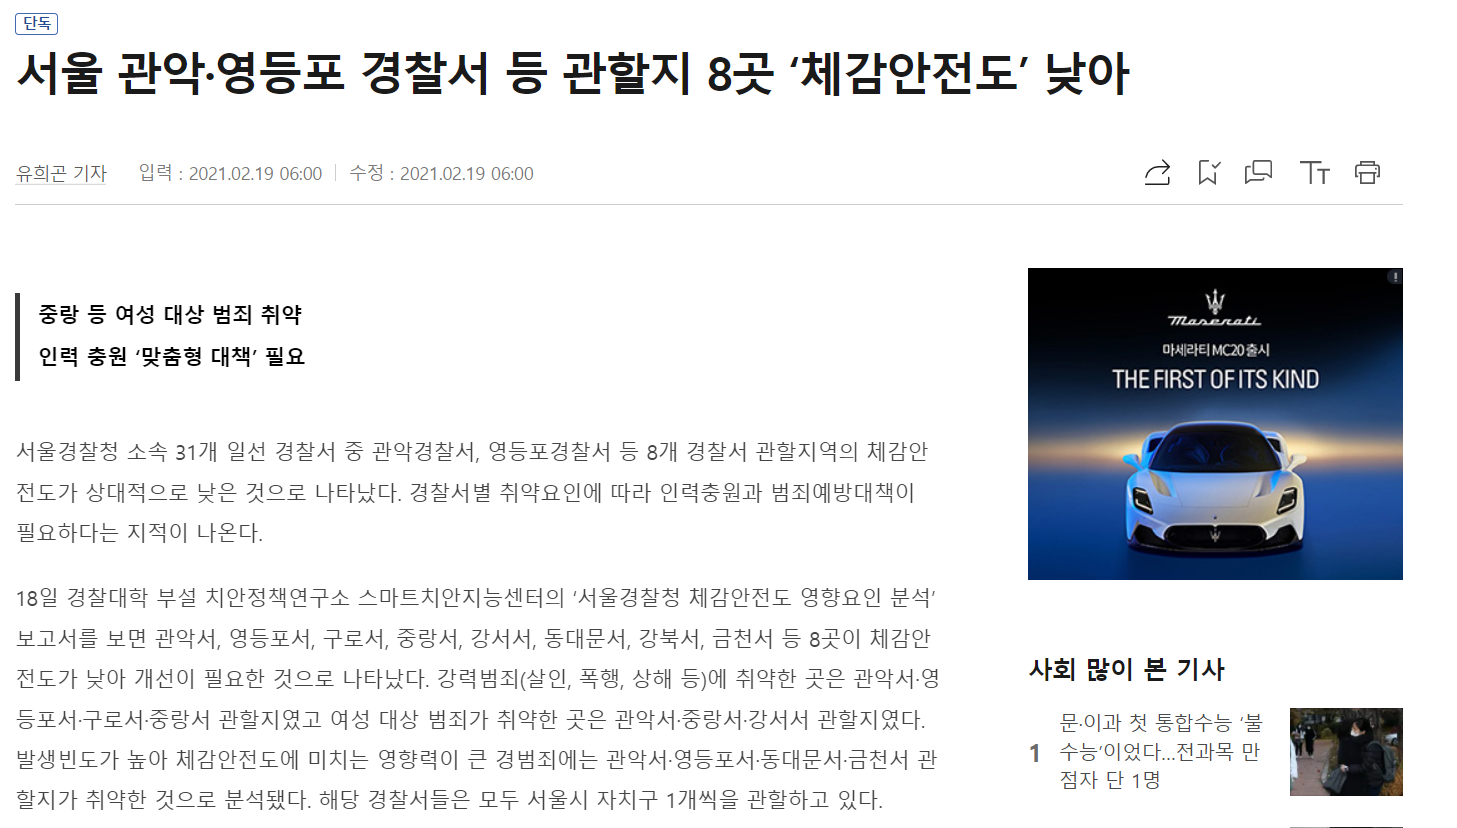

In [74]:
Image('C:/Users/whgud/TIL/Python/데이터분석_실습/서울_체감안전도_기사.png') 

### 분석목표 :  서울 관악, 영등포 경찰서 등 관할지 8곳이 체감안전도가 낮다는 기사를 검증해보겠습니다.
#### 체감안전도가 낮다고 하니, 서울시 구별 범죄 발생과, 그 검거율을 지표로 사용해 실제 안전도가 낮은지 살펴보겠습니다.
- 사용 데이터 : 서울 데이터 열린광장(https://data.seoul.go.kr/dataList/316/C/2/datasetView.do) - 서울시 5대 범죄 발생현황 통계(2020년) 
- 참고 문헌 : 파이썬으로 데이터 주무르기

##### 1. 데이터 불러오기

In [86]:
crime_anal_data = pd.read_excel('서울시_5대범죄_발생현황통계.xls',
                               names=['기간','자치구','발생 합계','검거 합계','살인 발생','살인 검거','강도 발생','강도 검거','강간강제추행 발생','강간강제추행 검거','절도 발생','절도 검거','폭력 발생','폭력 검거'],
                               header=None,
                               skiprows=3)
crime_anal_data.head()

,기간,자치구,발생 합계,검거 합계,살인 발생,살인 검거,강도 발생,강도 검거,강간강제추행 발생,강간강제추행 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,2020,종로구,3102,3343,9,7,7,9,192,855,1183,944,1711,1528
1,2020,중구,3411,2323,2,2,5,6,186,128,1642,863,1576,1324
2,2020,용산구,2969,2056,5,3,6,6,230,186,1111,534,1617,1327
3,2020,성동구,2362,1774,5,5,3,3,115,98,1016,565,1223,1103
4,2020,광진구,3601,2511,2,2,4,4,255,224,1664,874,1676,1407


##### 2. 데이터 전처리
- 불필요한 칼럼 제거, 검거 건수를 검거율로 대체

In [87]:
# 불필요한 칼럼 제거
crime_anal_data.drop(['기간','발생 합계','검거 합계'],axis=1, inplace = True)
crime_anal_data.head()

,자치구,살인 발생,살인 검거,강도 발생,강도 검거,강간강제추행 발생,강간강제추행 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,종로구,9,7,7,9,192,855,1183,944,1711,1528
1,중구,2,2,5,6,186,128,1642,863,1576,1324
2,용산구,5,3,6,6,230,186,1111,534,1617,1327
3,성동구,5,5,3,3,115,98,1016,565,1223,1103
4,광진구,2,2,4,4,255,224,1664,874,1676,1407


In [88]:
# 데이터 타입 확인
crime_anal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   자치구        25 non-null     object
 1   살인 발생      25 non-null     object
 2   살인 검거      25 non-null     object
 3   강도 발생      25 non-null     int64 
 4   강도 검거      25 non-null     int64 
 5   강간강제추행 발생  25 non-null     int64 
 6   강간강제추행 검거  25 non-null     int64 
 7   절도 발생      25 non-null     int64 
 8   절도 검거      25 non-null     int64 
 9   폭력 발생      25 non-null     int64 
 10  폭력 검거      25 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 2.3+ KB


In [89]:
# 살인 발생, 살인 검거를 - 를 0으로 대체
crime_anal_data['살인 검거'] = crime_anal_data['살인 검거'].replace('-',0)
crime_anal_data['살인 발생'] = crime_anal_data['살인 발생'].replace('-',0)

# 살인 발생, 살인 검거를 int형으로 변환
crime_anal_data['살인 검거'] = crime_anal_data['살인 검거'].astype(int)
crime_anal_data['살인 발생'] = crime_anal_data['살인 발생'].astype(int)

# 데이터 타입 확인
crime_anal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   자치구        25 non-null     object
 1   살인 발생      25 non-null     int32 
 2   살인 검거      25 non-null     int32 
 3   강도 발생      25 non-null     int64 
 4   강도 검거      25 non-null     int64 
 5   강간강제추행 발생  25 non-null     int64 
 6   강간강제추행 검거  25 non-null     int64 
 7   절도 발생      25 non-null     int64 
 8   절도 검거      25 non-null     int64 
 9   폭력 발생      25 non-null     int64 
 10  폭력 검거      25 non-null     int64 
dtypes: int32(2), int64(8), object(1)
memory usage: 2.1+ KB


In [90]:
# 검거 건수를 검거율로 대체
crime_anal_data['살인검거율'] = crime_anal_data['살인 검거']/crime_anal_data['살인 발생']*100
crime_anal_data['강도검거율'] = crime_anal_data['강도 검거']/crime_anal_data['강도 발생']*100
crime_anal_data['강간강제추행검거율'] = crime_anal_data['강간강제추행 검거']/crime_anal_data['강간강제추행 발생']*100
crime_anal_data['절도검거율'] = crime_anal_data['절도 검거']/crime_anal_data['절도 발생']*100
crime_anal_data['폭력검거율'] = crime_anal_data['폭력 검거']/crime_anal_data['폭력 발생']*100


# 검거 건수 칼럼 제거
del crime_anal_data['살인 검거']
del crime_anal_data['강도 검거']
del crime_anal_data['강간강제추행 검거']
del crime_anal_data['절도 검거']
del crime_anal_data['폭력 검거']

# 데이터 확인
crime_anal_data.head()

,자치구,살인 발생,강도 발생,강간강제추행 발생,절도 발생,폭력 발생,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
0,종로구,9,7,192,1183,1711,77.777778,128.571429,445.312500,79.797126,89.304500
1,중구,2,5,186,1642,1576,100.000000,120.000000,68.817204,52.557856,84.010152
2,용산구,5,6,230,1111,1617,60.000000,100.000000,80.869565,48.064806,82.065553
3,성동구,5,3,115,1016,1223,100.000000,100.000000,85.217391,55.610236,90.188062
4,광진구,2,4,255,1664,1676,100.000000,100.000000,87.843137,52.524038,83.949881


###### 검거율에 100이 넘는 숫자들이 존재  → 그 전년도 발생 건수에 대한 검거도 포함되어 그런 것으로 추정
- 학습을 목적으로 분석 진행중이기 때문에 100이 넘는 숫자는 100으로 대체

In [93]:
# 도봉구가 살인 발생이 0건, 검거도 0건이라 검거율이 결측값이 나와서 100으로 대체
crime_anal_data['살인검거율'].fillna(100.000000, inplace=True)

In [94]:
per_list = ['살인검거율','강도검거율','강간강제추행검거율','절도검거율','폭력검거율']

for column in per_list:
    crime_anal_data.loc[crime_anal_data[column]>100, column] = 100
crime_anal_data.head()

,자치구,살인 발생,강도 발생,강간강제추행 발생,절도 발생,폭력 발생,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
0,종로구,9,7,192,1183,1711,77.777778,100.0,100.000000,79.797126,89.304500
1,중구,2,5,186,1642,1576,100.000000,100.0,68.817204,52.557856,84.010152
2,용산구,5,6,230,1111,1617,60.000000,100.0,80.869565,48.064806,82.065553
3,성동구,5,3,115,1016,1223,100.000000,100.0,85.217391,55.610236,90.188062
4,광진구,2,4,255,1664,1676,100.000000,100.0,87.843137,52.524038,83.949881


In [95]:
# 칼럼이름에서 발생 제거
crime_anal_data.rename(columns = {'살인 발생' : '살인',
                          '강도 발생' : '강도',
                          '강간강제추행 발생' : '강간강제추행',
                           '절도 발생' : '절도',
                           '폭력 발생' : '폭력'
                          }, inplace = True)
crime_anal_data.head()

,자치구,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
0,종로구,9,7,192,1183,1711,77.777778,100.0,100.000000,79.797126,89.304500
1,중구,2,5,186,1642,1576,100.000000,100.0,68.817204,52.557856,84.010152
2,용산구,5,6,230,1111,1617,60.000000,100.0,80.869565,48.064806,82.065553
3,성동구,5,3,115,1016,1223,100.000000,100.0,85.217391,55.610236,90.188062
4,광진구,2,4,255,1664,1676,100.000000,100.0,87.843137,52.524038,83.949881


In [96]:
# 자치구를 인덱스로 세팅
crime_anal_data.set_index('자치구',inplace = True)
crime_anal_data.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
종로구,9,7,192,1183,1711,77.777778,100.0,100.000000,79.797126,89.304500
중구,2,5,186,1642,1576,100.000000,100.0,68.817204,52.557856,84.010152
용산구,5,6,230,1111,1617,60.000000,100.0,80.869565,48.064806,82.065553
성동구,5,3,115,1016,1223,100.000000,100.0,85.217391,55.610236,90.188062
광진구,2,4,255,1664,1676,100.000000,100.0,87.843137,52.524038,83.949881


##### 3. 데이터 정규화 
- 살인이나 강도사건에 비해, 절도, 폭력, 강간강제추행은 3~4자리수로 차이가 많이 나기 때문이다.
- scikit learn에 있는 preprocessing 도구 사용 (최소값, 최대값 이용)

In [97]:
from sklearn import preprocessing

col = ['살인','강도','강간강제추행','절도','폭력']

x = crime_anal_data[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled,
                              columns = col,
                              index = crime_anal_data.index)

col2 = ['살인검거율','강도검거율','강간강제추행검거율','절도검거율','폭력검거율']
crime_anal_norm[col2] = crime_anal_data[col2]
crime_anal_norm.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,77.777778,100.0,100.000000,79.797126,89.304500
중구,0.166667,0.285714,0.166134,0.397052,0.143847,100.000000,100.0,68.817204,52.557856,84.010152
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,60.000000,100.0,80.869565,48.064806,82.065553
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,100.000000,100.0,85.217391,55.610236,90.188062
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,100.000000,100.0,87.843137,52.524038,83.949881


In [98]:
#  서울시 구별 인구수와 CCTV 개수 가져오기
cctv_data = pd.read_csv('서울시_구별_cctv수_인구수.csv',
                       index_col = '구별' )
crime_anal_norm[['인구수','CCTV']] = cctv_data[['인구수','총계']]
crime_anal_norm.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,인구수,CCTV
자치구,,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,77.777778,100.0,100.000000,79.797126,89.304500,154318,1772
중구,0.166667,0.285714,0.166134,0.397052,0.143847,100.000000,100.0,68.817204,52.557856,84.010152,131943,2333
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,60.000000,100.0,80.869565,48.064806,82.065553,238300,2383
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,100.000000,100.0,85.217391,55.610236,90.188062,294140,3602
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,100.000000,100.0,87.843137,52.524038,83.949881,353380,2588


In [99]:
# 발생 건수의 합을 '범죄'라는 칼럼으로 생성
col = ['살인','강도','강간강제추행','절도','폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
자치구,,,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,77.777778,100.0,100.000000,79.797126,89.304500,154318,1772,1.738778
중구,0.166667,0.285714,0.166134,0.397052,0.143847,100.000000,100.0,68.817204,52.557856,84.010152,131943,2333,1.159414
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,60.000000,100.0,80.869565,48.064806,82.065553,238300,2383,1.323250
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,100.000000,100.0,85.217391,55.610236,90.188062,294140,3602,0.720945
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,100.000000,100.0,87.843137,52.524038,83.949881,353380,2588,1.249092


In [100]:
# '검거'라는 이름의 칼럼으로 통합 검거율 생성
col = ['살인검거율','강도검거율','강간강제추행검거율','절도검거율','폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,77.777778,100.000000,100.000000,79.797126,89.304500,154318,1772,1.738778,446.879404
중구,0.166667,0.285714,0.166134,0.397052,0.143847,100.000000,100.000000,68.817204,52.557856,84.010152,131943,2333,1.159414,405.385213
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,60.000000,100.000000,80.869565,48.064806,82.065553,238300,2383,1.323250,370.999925
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,100.000000,100.000000,85.217391,55.610236,90.188062,294140,3602,0.720945,431.015690
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,100.000000,100.000000,87.843137,52.524038,83.949881,353380,2588,1.249092,424.317056
동대문구,0.833333,0.357143,0.126198,0.304007,0.228606,80.000000,83.333333,88.198758,49.513889,89.517937,351626,2497,1.849288,390.563917
중랑구,0.833333,0.285714,0.161342,0.334408,0.325591,90.000000,100.000000,83.606557,59.030544,85.262117,393149,3296,1.940388,417.899219
성북구,0.333333,0.142857,0.095847,0.095808,0.084352,100.000000,66.666667,85.211268,58.704453,86.713287,441717,3958,0.752198,397.295674
강북구,0.750000,0.285714,0.123003,0.000000,0.242054,88.888889,80.000000,83.018868,62.820513,89.433132,304257,2462,1.400771,404.161401


##### 4. 시각화

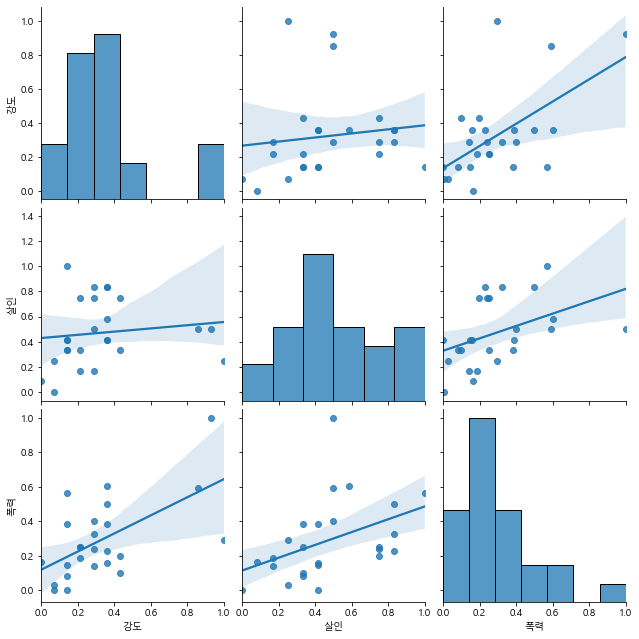

In [101]:
sns.pairplot(crime_anal_norm, vars=['강도','살인','폭력'], kind = 'reg', height = 3)
plt.show()

강도와 폭력, 강도와 살인, 살인과 폭력이 양의 상관관계를 보인다.

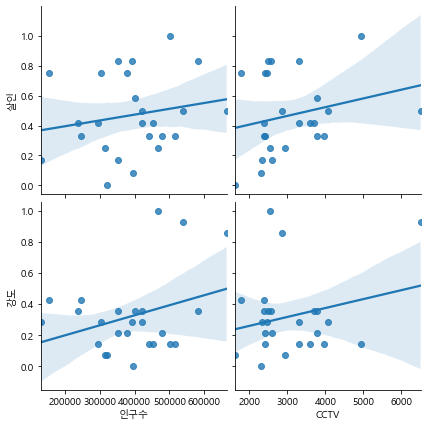

In [102]:
sns.pairplot(crime_anal_norm, x_vars = ['인구수','CCTV'],
            y_vars = ['살인','강도'], kind = 'reg', height = 3)
plt.show()

CCTV가 적을때 살인이나, 강도가 CCTV가 많을때보다 더 많이 발생한다.

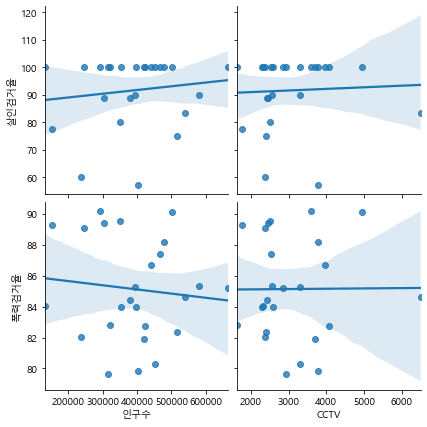

In [103]:
sns.pairplot(crime_anal_norm,
            x_vars = ['인구수','CCTV'],
            y_vars = ['살인검거율','폭력검거율'], kind ='reg', height = 3)
plt.show()

CCTV와 인구수가 많다고 해서 살인및 폭력검거율이 높아지는 것은 아니다.

In [104]:
tmp_max = crime_anal_norm['검거'].max() # 검거율의 합계인 검거항목 최고값을 100으로 한정
crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max * 100
crime_anal_norm_sort = crime_anal_norm.sort_values(by = '검거',ascending = False) # 검거를 기준으로 내림차순 정렬
crime_anal_norm_sort.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,77.777778,100.0,100.000000,79.797126,89.304500,154318,1772,1.738778,100.000000
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,100.000000,100.0,85.217391,55.610236,90.188062,294140,3602,0.720945,96.450113
관악구,1.000000,0.142857,0.512780,0.667434,0.566830,100.000000,100.0,87.096774,51.009421,90.091813,501572,4942,2.889901,95.819589
도봉구,0.000000,0.071429,0.000000,0.037310,0.004482,100.000000,100.0,100.000000,44.018583,82.820097,320711,1629,0.113221,95.515407
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,100.000000,100.0,87.843137,52.524038,83.949881,353380,2588,1.249092,94.951133


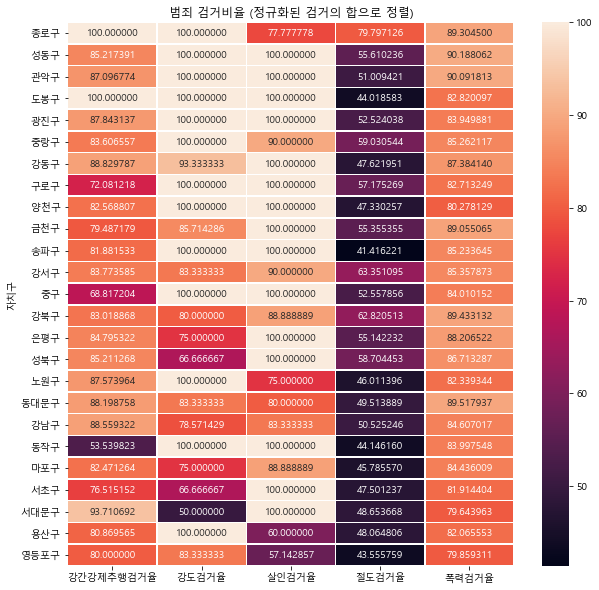

In [105]:
target_col = ['강간강제추행검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm_sort =  crime_anal_norm.sort_values(by = '검거',ascending = False) 
plt.figure(figsize = (10,10))
sns.heatmap(crime_anal_norm_sort[target_col], annot=True , fmt='f', linewidths=.5)
plt.title('범죄 검거비율 (정규화된 검거의 합으로 정렬)')
plt.show()

전반적으로 검거율이 우수한 구는 '종로구', '성동구', '관악구' ,'광진구'로 보입니다